In [1]:
from heston import simulate, get_observed_process
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import clear_output
plt.style.use('dark_background')

In [2]:
PREDICTION_PERIOD = 60

TRAIN_PERIOD = 10 * 360
TEST_PERIOD = 1 * 360

NUM_TRAINING_SAMPLES = 100
NUM_TEST_SAMPLES = 10

STOCK_NAME = "MSFT"

In [ ]:
def loss():
    

In [3]:
end = datetime.today() - timedelta(days=1)
start = end - timedelta(days=TRAIN_PERIOD)
observed_process = get_observed_process(STOCK_NAME, start, end, interval="1d", local_vol_window_size=5)

[*********************100%***********************]  1 of 1 completed


In [4]:
def sample_sub_observed_processes(mode="train"):
    if mode == "train":
        size = NUM_TRAINING_SAMPLES
        low = 0
        high = observed_process[observed_process.index < end - timedelta(days=TEST_PERIOD + PREDICTION_PERIOD)].shape[0]
    elif mode == "test":
        size = NUM_TEST_SAMPLES
        low = observed_process[observed_process.index < end - timedelta(days=TEST_PERIOD)].shape[0]
        high = observed_process[observed_process.index < end - timedelta(days=PREDICTION_PERIOD)].shape[0]
    for i in np.random.randint(low=low, high=high, size=(size, )):
        yield observed_process.iloc[i : i + PREDICTION_PERIOD]

In [5]:
all_parameters = {}

for sub_observed_process in sample_sub_observed_processes(mode="train"):
    simulation, parameters, sub_observed_process = simulate(observed_process=sub_observed_process, plot=False)
    all_parameters[sub_observed_process.index[-1]] = parameters
all_parameters = pd.DataFrame.from_dict(all_parameters, orient="index")
parameters = dict(all_parameters.mean())

clear_output()

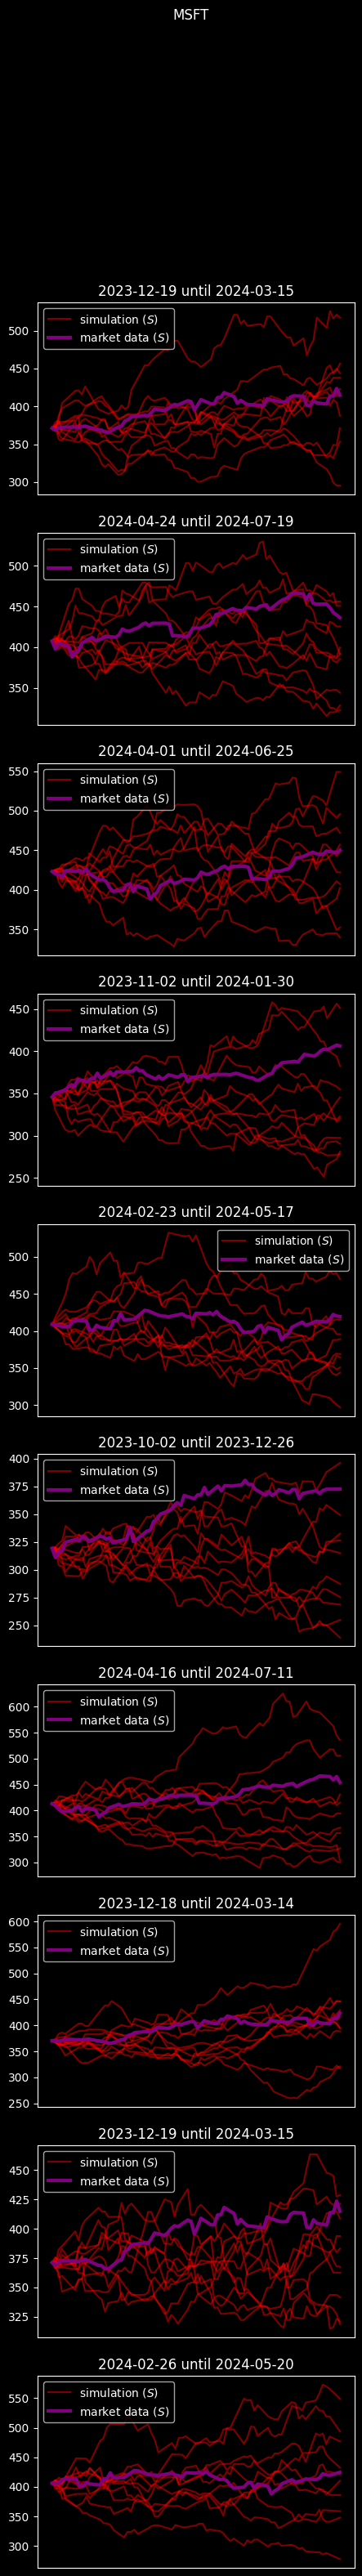

In [6]:
fig, axs = plt.subplots(NUM_TEST_SAMPLES, 1)
fig.set_size_inches(5, 36)
for i, sub_observed_process in enumerate(sample_sub_observed_processes(mode="test")):
    simulation, parameters, sub_observed_process = simulate(observed_process=sub_observed_process, parameters=parameters)
    for j, trajectory in enumerate(simulation[..., 0].transpose(0, 1)):
        axs[i].plot(sub_observed_process.index, trajectory, c="red", alpha=.5, label="simulation ($S$)" if j == 0 else None)
    axs[i].plot(sub_observed_process.index, list(sub_observed_process["S"]), c="purple", linewidth=3, label="market data ($S$)")
    axs[i].set_title(f"{sub_observed_process.index[0].date()} until {sub_observed_process.index[-1].date()}")
    axs[i].legend()
    axs[i].set_xticks([])
fig.suptitle(STOCK_NAME)
clear_output()
plt.show()
